In [2]:
pip install medmnist timm torch torchvision -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import AutoAugment, AutoAugmentPolicy
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import os
import requests
import zipfile
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import medmnist

from torch.utils.data import Subset

/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.cuda.empty_cache()

In [18]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [6]:
class NumpyDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        image = (image * 255).astype(np.uint8)
        label = int(label) # int label 1d

        # CHW
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [7]:
path = '/home/dime/Desktop/Pre-thesis/data/dermamnist_224'

In [8]:
from collections import Counter

def compute_class_counts(labels_path):
    labels = np.load(labels_path).flatten()  
    return dict(Counter(labels))  

In [9]:
img_size=224

batch_size = 32

epochs = 30

num_epochs = 30

learning_rate = 0.001

num_classes = 7

In [10]:
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

In [11]:
def load_datasets(img_size=img_size, batch_size=batch_size):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [12]:
train_class_counts = compute_class_counts(os.path.join(path, 'train_labels.npy'))
val_class_counts = compute_class_counts(os.path.join(path, 'val_labels.npy'))
test_class_counts = compute_class_counts(os.path.join(path, 'test_labels.npy'))

print('Train class counts:', train_class_counts)
print('Val class counts:', val_class_counts)
print('Test class counts:', test_class_counts)

Train class counts: {0: 228, 5: 4693, 4: 779, 2: 769, 1: 359, 6: 99, 3: 80}
Val class counts: {5: 671, 4: 111, 2: 110, 6: 14, 1: 52, 0: 33, 3: 12}
Test class counts: {5: 1341, 3: 23, 4: 223, 0: 66, 2: 220, 1: 103, 6: 29}


In [13]:
class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.vit = create_model('vit_large_patch16_224', pretrained=True, num_classes=num_classes)

        self.vit.head = nn.Sequential(
            nn.Dropout(0.1),
            self.vit.head
        )

    def forward(self, x):
        return self.vit(x)

In [27]:
def plot_metrics(metrics_log):
    epochs = range(1, len(metrics_log["train_loss"]) + 1)

    # Plot loss
    plt.figure()
    plt.plot(epochs, metrics_log["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics_log["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, metrics_log["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, metrics_log["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.show()

    # Plot F1 score
    plt.figure()
    plt.plot(epochs, metrics_log["train_f1"], label="Train F1 Score")
    plt.plot(epochs, metrics_log["val_f1"], label="Validation F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("F1 Score vs Epochs")
    plt.legend()
    plt.show()

In [ ]:
def train_model(
    model, train_loader, val_loader, device, num_epochs=num_epochs, lr=learning_rate, patience=5, accumulation_steps=4
):

    for param in model.vit.parameters():
        param.requires_grad = False

    for param in model.vit.head.parameters():
        param.requires_grad = True

    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        for step, (images, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)  # memory fragmentation
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps  

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item() * accumulation_steps  
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss /= len(val_loader)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "vit_best_model.pth")  
            print("Validation loss improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print("Early stopping")
            break

    print(f"Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"Final Val F1: {metrics_log['val_f1'][-1]:.4f}")

    plot_metrics(metrics_log)
    return metrics_log



Training Epoch 1/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [1/30]:
  Train Loss: 1.7569, Accuracy: 0.4575, F1: 0.4613
  Val Loss: 1.3348, Accuracy: 0.6580, F1: 0.5313
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [2/30]:
  Train Loss: 1.3601, Accuracy: 0.6355, F1: 0.5357
  Val Loss: 1.3010, Accuracy: 0.6680, F1: 0.5365
Validation loss improved. Model saved.


Training Epoch 3/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [3/30]:
  Train Loss: 1.2747, Accuracy: 0.6508, F1: 0.5362
  Val Loss: 1.2013, Accuracy: 0.6640, F1: 0.5342
Validation loss improved. Model saved.


Training Epoch 4/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [4/30]:
  Train Loss: 1.2437, Accuracy: 0.6592, F1: 0.5377
  Val Loss: 1.1909, Accuracy: 0.6650, F1: 0.5344
Validation loss improved. Model saved.


Training Epoch 5/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [5/30]:
  Train Loss: 1.2448, Accuracy: 0.6572, F1: 0.5380
  Val Loss: 1.1959, Accuracy: 0.6640, F1: 0.5360
No improvement in validation loss for 1 epochs.


Training Epoch 6/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [6/30]:
  Train Loss: 1.2198, Accuracy: 0.6566, F1: 0.5370
  Val Loss: 1.1702, Accuracy: 0.6660, F1: 0.5355
Validation loss improved. Model saved.


Training Epoch 7/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [7/30]:
  Train Loss: 1.2028, Accuracy: 0.6612, F1: 0.5364
  Val Loss: 1.2464, Accuracy: 0.6680, F1: 0.5358
No improvement in validation loss for 1 epochs.


Training Epoch 8/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [8/30]:
  Train Loss: 1.2480, Accuracy: 0.6476, F1: 0.5359
  Val Loss: 1.1630, Accuracy: 0.6650, F1: 0.5368
Validation loss improved. Model saved.


Training Epoch 9/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [9/30]:
  Train Loss: 1.2033, Accuracy: 0.6612, F1: 0.5388
  Val Loss: 1.1400, Accuracy: 0.6680, F1: 0.5383
Validation loss improved. Model saved.


Training Epoch 10/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [10/30]:
  Train Loss: 1.2009, Accuracy: 0.6599, F1: 0.5372
  Val Loss: 1.1995, Accuracy: 0.6670, F1: 0.5357
No improvement in validation loss for 1 epochs.


Training Epoch 11/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [11/30]:
  Train Loss: 1.1984, Accuracy: 0.6598, F1: 0.5358
  Val Loss: 1.1582, Accuracy: 0.6680, F1: 0.5368
No improvement in validation loss for 2 epochs.


Training Epoch 12/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [12/30]:
  Train Loss: 1.1885, Accuracy: 0.6618, F1: 0.5398
  Val Loss: 1.1510, Accuracy: 0.6680, F1: 0.5358
No improvement in validation loss for 3 epochs.


Training Epoch 13/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [13/30]:
  Train Loss: 1.1996, Accuracy: 0.6648, F1: 0.5389
  Val Loss: 1.1534, Accuracy: 0.6690, F1: 0.5381
No improvement in validation loss for 4 epochs.


Training Epoch 14/30:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipykernel_6864/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [14/30]:
  Train Loss: 1.2006, Accuracy: 0.6625, F1: 0.5418
  Val Loss: 1.1782, Accuracy: 0.6640, F1: 0.5342
No improvement in validation loss for 5 epochs.
Early stopping
Final Train Loss: 1.2006
Final Train Accuracy: 0.6625
Final Train F1: 0.5418
Final Val Loss: 1.1782
Final Val Accuracy: 0.6640
Final Val F1: 0.5342


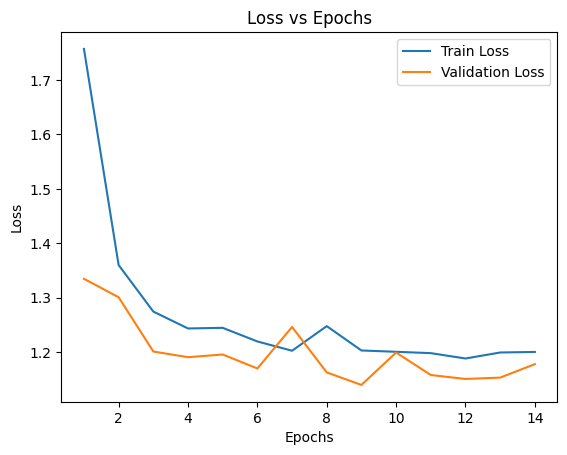

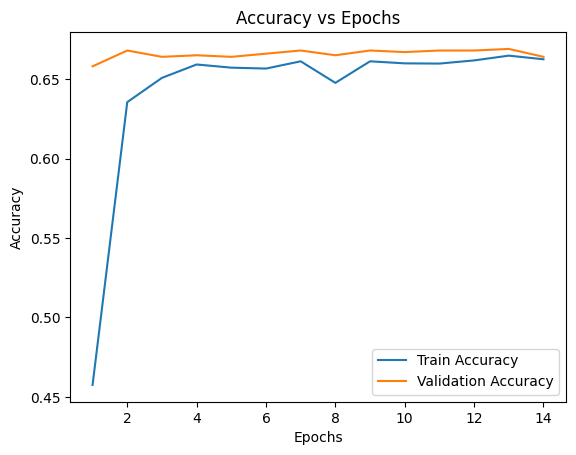

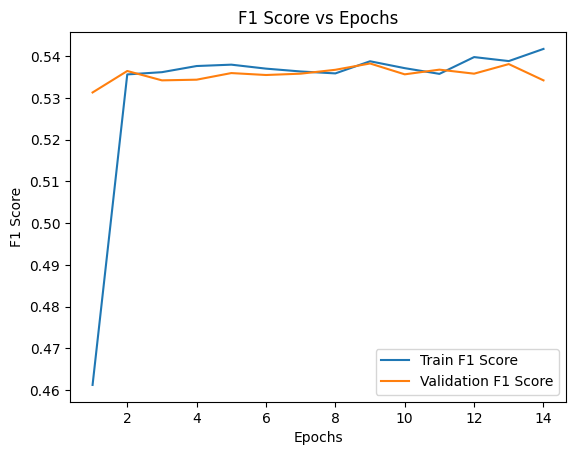

In [18]:
if __name__ == "__main__":
    train_loader, val_loader, test_loader = load_datasets(batch_size, img_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTModel(num_classes=num_classes)

    train_model(model, train_loader, val_loader, device, num_epochs, learning_rate)

In [21]:
#save model 
path = '/home/dime/Desktop/Pre-thesis'
torch.save(model.state_dict(), os.path.join(path, 'vit_model_30epochs.pth'))

## 10%

In [25]:
# added shuffle for train
# count as well the amount of data 

percentage = 10

def subset_dataset_percentage(dataset, labels_path, percentage=percentage, seed=42):
    random.seed(seed)
    labels = np.load(labels_path).flatten()
    class_indices = defaultdict(list)

    for idx, label in enumerate(labels):
        class_indices[label].append(idx)
    
    subset_indices = []
    for indices in class_indices.values():
        subset_size = max(1, len(indices) * percentage // 100)
        subset_indices.extend(random.sample(indices, subset_size))
    
    return Subset(dataset, subset_indices)

def load_data_subset(batch_size=batch_size, img_size=img_size, percentage=percentage):
    train_dataset = NumpyDataset(os.path.join(path, 'train_images.npy'), os.path.join(path, 'train_labels.npy'), transform)
    val_dataset = NumpyDataset(os.path.join(path, 'val_images.npy'), os.path.join(path, 'val_labels.npy'), transform)
    test_dataset = NumpyDataset(os.path.join(path, 'test_images.npy'), os.path.join(path, 'test_labels.npy'), transform)

    train_subset = subset_dataset_percentage(train_dataset, os.path.join(path, 'train_labels.npy'), percentage=percentage, seed=42)
    val_subset = val_dataset
    test_subset = test_dataset

    train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True) # shuffle the training data! 
    val_loader_subset = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader_subset = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader_subset, val_loader_subset, test_loader_subset   

In [15]:
train_subset_class_counts = compute_class_counts(os.path.join(path, 'train_labels.npy'))
train_subset_class_counts

{0: 228, 5: 4693, 4: 779, 2: 769, 1: 359, 6: 99, 3: 80}

In [23]:
def train_subset_model(
    model,
    train_loader_subset,
    val_loader_subset,
    device,
    num_epochs=30,
    lr=0.001,
    patience=5,
    accumulation_steps=4
):
    # Freeze everything except the head
    for param in model.vit.parameters():
        param.requires_grad = False
    for param in model.vit.head.parameters():
        param.requires_grad = True

    metrics_log = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_f1": []
    }

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.cuda.amp.GradScaler()

    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        all_labels, all_preds = [], []

        # Training loop
        for step, (images, labels) in enumerate(tqdm(train_loader_subset, desc=f"Training Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps

            scaler.scale(loss).backward()

            if (step + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            running_loss += loss.item() * accumulation_steps
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_accuracy = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        train_loss = running_loss / len(train_loader_subset)

        # Validation loop
        model.eval()
        val_loss_total = 0.0
        val_labels, val_preds = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader_subset, desc="Validating"):
                images, labels = images.to(device), labels.to(device)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss_total += loss.item()

                _, predicted = outputs.max(1)
                val_labels.extend(labels.cpu().numpy())
                val_preds.extend(predicted.cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_loss_avg = val_loss_total / len(val_loader_subset)

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_accuracy"].append(train_accuracy)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_loss"].append(val_loss_avg)
        metrics_log["val_accuracy"].append(val_accuracy)
        metrics_log["val_f1"].append(val_f1)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}]:")
        print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Loss: {val_loss_avg:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}")

        # Early stopping check
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            torch.save(model.state_dict(), "vit_best_model_10%.pth")
            print("Validation loss improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")

        if patience_counter >= patience:
            print("Early stopping")
            break

    # Optionally, plot or print final
    print(f"Final Train Loss: {metrics_log['train_loss'][-1]:.4f}")
    print(f"Final Train Accuracy: {metrics_log['train_accuracy'][-1]:.4f}")
    print(f"Final Train F1: {metrics_log['train_f1'][-1]:.4f}")
    print(f"Final Val Loss: {metrics_log['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {metrics_log['val_accuracy'][-1]:.4f}")
    print(f"Final Val F1: {metrics_log['val_f1'][-1]:.4f}")

    plot_metrics(metrics_log)
    return metrics_log


===== RUN 1/3 (Percentage=10%) =====


Training Epoch 1/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [1/30]:
  Train Loss: 2.0248, Accuracy: 0.3032, F1: 0.3589
  Val Loss: 1.4684, Accuracy: 0.6630, F1: 0.5350
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [2/30]:
  Train Loss: 1.5207, Accuracy: 0.5848, F1: 0.5077
  Val Loss: 1.4069, Accuracy: 0.5523, F1: 0.5046
Validation loss improved. Model saved.


Training Epoch 3/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [3/30]:
  Train Loss: 1.4297, Accuracy: 0.6149, F1: 0.5324
  Val Loss: 1.4724, Accuracy: 0.6660, F1: 0.5349
No improvement in validation loss for 1 epoch(s).


Training Epoch 4/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [4/30]:
  Train Loss: 1.4976, Accuracy: 0.6408, F1: 0.5373
  Val Loss: 1.4681, Accuracy: 0.5643, F1: 0.5048
No improvement in validation loss for 2 epoch(s).


Training Epoch 5/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [5/30]:
  Train Loss: 1.4337, Accuracy: 0.5517, F1: 0.5016
  Val Loss: 1.2766, Accuracy: 0.6580, F1: 0.5339
Validation loss improved. Model saved.


Training Epoch 6/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [6/30]:
  Train Loss: 1.3016, Accuracy: 0.6624, F1: 0.5552
  Val Loss: 1.2962, Accuracy: 0.6550, F1: 0.5359
No improvement in validation loss for 1 epoch(s).


Training Epoch 7/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [7/30]:
  Train Loss: 1.3415, Accuracy: 0.6178, F1: 0.5408
  Val Loss: 1.3530, Accuracy: 0.6620, F1: 0.5369
No improvement in validation loss for 2 epoch(s).


Training Epoch 8/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [8/30]:
  Train Loss: 1.3063, Accuracy: 0.6552, F1: 0.5424
  Val Loss: 1.2803, Accuracy: 0.6481, F1: 0.5304
No improvement in validation loss for 3 epoch(s).


Training Epoch 9/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [9/30]:
  Train Loss: 1.3514, Accuracy: 0.6006, F1: 0.5227
  Val Loss: 1.2188, Accuracy: 0.6630, F1: 0.5416
Validation loss improved. Model saved.


Training Epoch 10/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [10/30]:
  Train Loss: 1.2603, Accuracy: 0.6351, F1: 0.5438
  Val Loss: 1.2235, Accuracy: 0.6680, F1: 0.5378
No improvement in validation loss for 1 epoch(s).


Training Epoch 11/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [11/30]:
  Train Loss: 1.2524, Accuracy: 0.6552, F1: 0.5429
  Val Loss: 1.2472, Accuracy: 0.6660, F1: 0.5349
No improvement in validation loss for 2 epoch(s).


Training Epoch 12/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [12/30]:
  Train Loss: 1.2815, Accuracy: 0.6595, F1: 0.5401
  Val Loss: 1.2263, Accuracy: 0.6680, F1: 0.5362
No improvement in validation loss for 3 epoch(s).


Training Epoch 13/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [13/30]:
  Train Loss: 1.2626, Accuracy: 0.6624, F1: 0.5379
  Val Loss: 1.1909, Accuracy: 0.6700, F1: 0.5386
Validation loss improved. Model saved.


Training Epoch 14/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [14/30]:
  Train Loss: 1.2465, Accuracy: 0.6566, F1: 0.5418
  Val Loss: 1.1649, Accuracy: 0.6660, F1: 0.5349
Validation loss improved. Model saved.


Training Epoch 15/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [15/30]:
  Train Loss: 1.2453, Accuracy: 0.6681, F1: 0.5427
  Val Loss: 1.2537, Accuracy: 0.6680, F1: 0.5362
No improvement in validation loss for 1 epoch(s).


Training Epoch 16/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [16/30]:
  Train Loss: 1.2583, Accuracy: 0.6652, F1: 0.5413
  Val Loss: 1.2004, Accuracy: 0.6650, F1: 0.5344
No improvement in validation loss for 2 epoch(s).


Training Epoch 17/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [17/30]:
  Train Loss: 1.2453, Accuracy: 0.6264, F1: 0.5423
  Val Loss: 1.2270, Accuracy: 0.6351, F1: 0.5350
No improvement in validation loss for 3 epoch(s).


Training Epoch 18/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [18/30]:
  Train Loss: 1.2824, Accuracy: 0.6164, F1: 0.5241
  Val Loss: 1.1997, Accuracy: 0.6680, F1: 0.5376
No improvement in validation loss for 4 epoch(s).


Training Epoch 19/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [19/30]:
  Train Loss: 1.2265, Accuracy: 0.6724, F1: 0.5474
  Val Loss: 1.2306, Accuracy: 0.6680, F1: 0.5362
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 1.2265
Final Train Accuracy: 0.6724
Final Train F1: 0.5474
Final Val Loss: 1.2306
Final Val Accuracy: 0.6680
Final Val F1: 0.5362


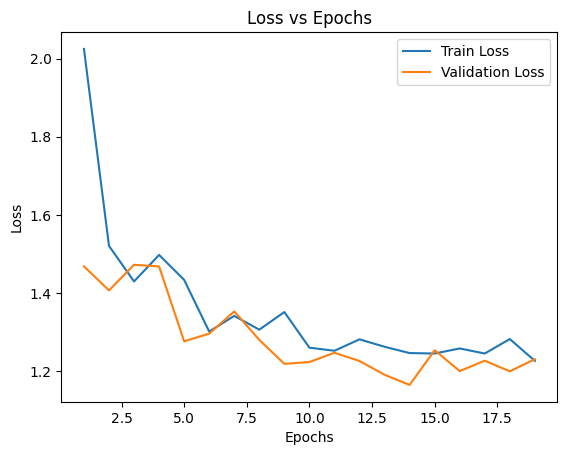

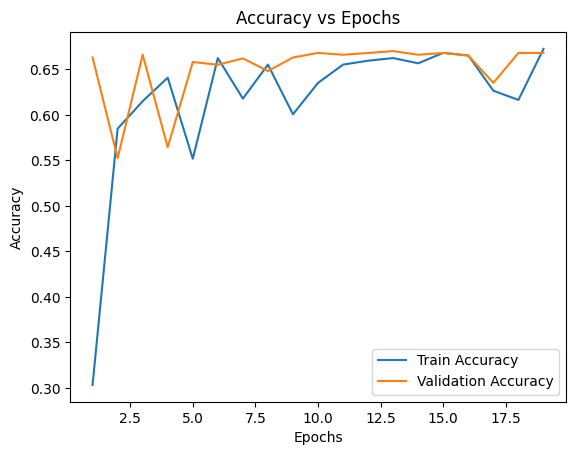

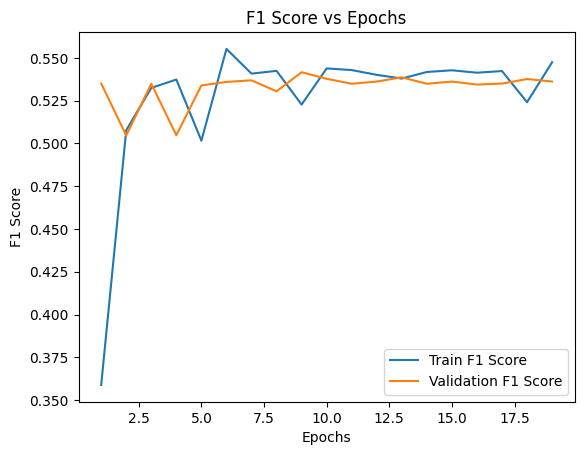

Run 1 - Final Val Accuracy: 0.6680
Run 1 - Final Val F1:       0.5362
Run 1 - Final Val Loss:     1.2306

===== RUN 2/3 (Percentage=10%) =====


Training Epoch 1/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [1/30]:
  Train Loss: 1.8145, Accuracy: 0.3836, F1: 0.4244
  Val Loss: 1.3713, Accuracy: 0.6411, F1: 0.5241
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [2/30]:
  Train Loss: 1.4616, Accuracy: 0.5833, F1: 0.5125
  Val Loss: 1.3605, Accuracy: 0.6401, F1: 0.5301
Validation loss improved. Model saved.


Training Epoch 3/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [3/30]:
  Train Loss: 1.3613, Accuracy: 0.6509, F1: 0.5466
  Val Loss: 1.3276, Accuracy: 0.6620, F1: 0.5402
Validation loss improved. Model saved.


Training Epoch 4/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [4/30]:
  Train Loss: 1.3527, Accuracy: 0.6307, F1: 0.5439
  Val Loss: 1.3119, Accuracy: 0.6132, F1: 0.5309
Validation loss improved. Model saved.


Training Epoch 5/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [5/30]:
  Train Loss: 1.4502, Accuracy: 0.6106, F1: 0.5269
  Val Loss: 1.4112, Accuracy: 0.6660, F1: 0.5403
No improvement in validation loss for 1 epoch(s).


Training Epoch 6/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [6/30]:
  Train Loss: 1.3469, Accuracy: 0.6609, F1: 0.5429
  Val Loss: 1.3131, Accuracy: 0.6610, F1: 0.5391
No improvement in validation loss for 2 epoch(s).


Training Epoch 7/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [7/30]:
  Train Loss: 1.3365, Accuracy: 0.6394, F1: 0.5309
  Val Loss: 1.2342, Accuracy: 0.6510, F1: 0.5319
Validation loss improved. Model saved.


Training Epoch 8/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [8/30]:
  Train Loss: 1.2767, Accuracy: 0.6379, F1: 0.5427
  Val Loss: 1.2098, Accuracy: 0.6680, F1: 0.5402
Validation loss improved. Model saved.


Training Epoch 9/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [9/30]:
  Train Loss: 1.2160, Accuracy: 0.6667, F1: 0.5409
  Val Loss: 1.1999, Accuracy: 0.6630, F1: 0.5383
Validation loss improved. Model saved.


Training Epoch 10/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [10/30]:
  Train Loss: 1.2763, Accuracy: 0.6293, F1: 0.5322
  Val Loss: 1.2397, Accuracy: 0.6660, F1: 0.5396
No improvement in validation loss for 1 epoch(s).


Training Epoch 11/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [11/30]:
  Train Loss: 1.2689, Accuracy: 0.6552, F1: 0.5436
  Val Loss: 1.2314, Accuracy: 0.6630, F1: 0.5334
No improvement in validation loss for 2 epoch(s).


Training Epoch 12/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [12/30]:
  Train Loss: 1.2882, Accuracy: 0.6681, F1: 0.5508
  Val Loss: 1.2118, Accuracy: 0.6630, F1: 0.5361
No improvement in validation loss for 3 epoch(s).


Training Epoch 13/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [13/30]:
  Train Loss: 1.2454, Accuracy: 0.6422, F1: 0.5426
  Val Loss: 1.2186, Accuracy: 0.6570, F1: 0.5427
No improvement in validation loss for 4 epoch(s).


Training Epoch 14/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [14/30]:
  Train Loss: 1.2429, Accuracy: 0.6451, F1: 0.5425
  Val Loss: 1.2266, Accuracy: 0.6610, F1: 0.5334
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 1.2429
Final Train Accuracy: 0.6451
Final Train F1: 0.5425
Final Val Loss: 1.2266
Final Val Accuracy: 0.6610
Final Val F1: 0.5334


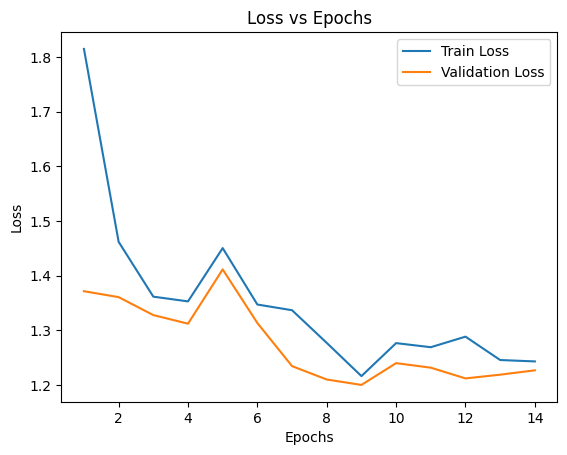

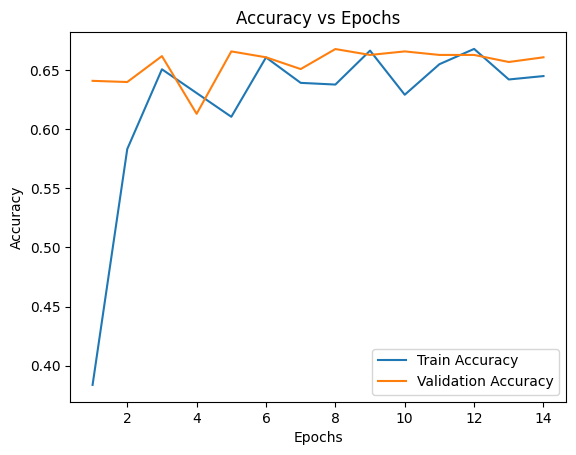

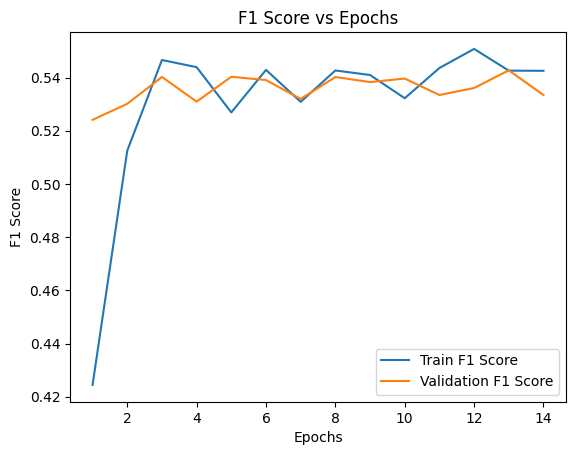

Run 2 - Final Val Accuracy: 0.6610
Run 2 - Final Val F1:       0.5334
Run 2 - Final Val Loss:     1.2266

===== RUN 3/3 (Percentage=10%) =====


Training Epoch 1/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [1/30]:
  Train Loss: 2.5187, Accuracy: 0.2399, F1: 0.2582
  Val Loss: 1.8157, Accuracy: 0.5105, F1: 0.4828
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [2/30]:
  Train Loss: 1.7469, Accuracy: 0.6106, F1: 0.5296
  Val Loss: 1.7578, Accuracy: 0.6351, F1: 0.5334
Validation loss improved. Model saved.


Training Epoch 3/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [3/30]:
  Train Loss: 1.6208, Accuracy: 0.6135, F1: 0.5285
  Val Loss: 1.4921, Accuracy: 0.6251, F1: 0.5232
Validation loss improved. Model saved.


Training Epoch 4/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [4/30]:
  Train Loss: 1.4994, Accuracy: 0.6408, F1: 0.5397
  Val Loss: 1.4148, Accuracy: 0.6580, F1: 0.5320
Validation loss improved. Model saved.


Training Epoch 5/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [5/30]:
  Train Loss: 1.3851, Accuracy: 0.6523, F1: 0.5416
  Val Loss: 1.2842, Accuracy: 0.6401, F1: 0.5301
Validation loss improved. Model saved.


Training Epoch 6/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [6/30]:
  Train Loss: 1.3506, Accuracy: 0.5704, F1: 0.5132
  Val Loss: 1.3214, Accuracy: 0.6092, F1: 0.5232
No improvement in validation loss for 1 epoch(s).


Training Epoch 7/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [7/30]:
  Train Loss: 1.3137, Accuracy: 0.6437, F1: 0.5488
  Val Loss: 1.3137, Accuracy: 0.6680, F1: 0.5362
No improvement in validation loss for 2 epoch(s).


Training Epoch 8/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [8/30]:
  Train Loss: 1.3057, Accuracy: 0.6523, F1: 0.5348
  Val Loss: 1.2071, Accuracy: 0.6660, F1: 0.5373
Validation loss improved. Model saved.


Training Epoch 9/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from t

Epoch [9/30]:
  Train Loss: 1.2753, Accuracy: 0.6480, F1: 0.5355
  Val Loss: 1.2383, Accuracy: 0.6660, F1: 0.5349
No improvement in validation loss for 1 epoch(s).


Training Epoch 10/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [10/30]:
  Train Loss: 1.3136, Accuracy: 0.6466, F1: 0.5339
  Val Loss: 1.2683, Accuracy: 0.6610, F1: 0.5357
No improvement in validation loss for 2 epoch(s).


Training Epoch 11/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [11/30]:
  Train Loss: 1.2888, Accuracy: 0.6049, F1: 0.5327
  Val Loss: 1.2377, Accuracy: 0.6600, F1: 0.5354
No improvement in validation loss for 3 epoch(s).


Training Epoch 12/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [12/30]:
  Train Loss: 1.2739, Accuracy: 0.6552, F1: 0.5433
  Val Loss: 1.2504, Accuracy: 0.6680, F1: 0.5379
No improvement in validation loss for 4 epoch(s).


Training Epoch 13/30:   0%|          | 0/22 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from 

Epoch [13/30]:
  Train Loss: 1.3104, Accuracy: 0.6494, F1: 0.5341
  Val Loss: 1.2330, Accuracy: 0.6690, F1: 0.5363
No improvement in validation loss for 5 epoch(s).
Early stopping
Final Train Loss: 1.3104
Final Train Accuracy: 0.6494
Final Train F1: 0.5341
Final Val Loss: 1.2330
Final Val Accuracy: 0.6690
Final Val F1: 0.5363


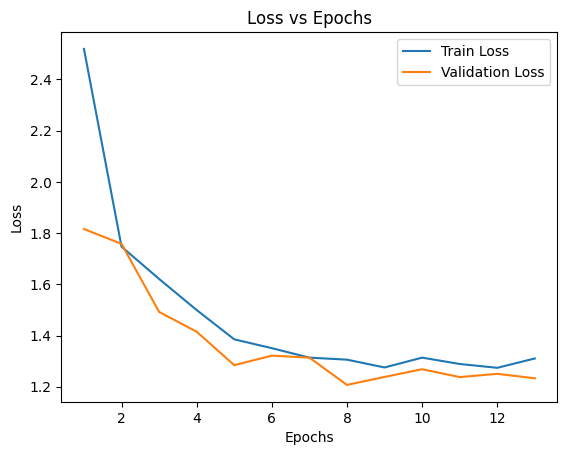

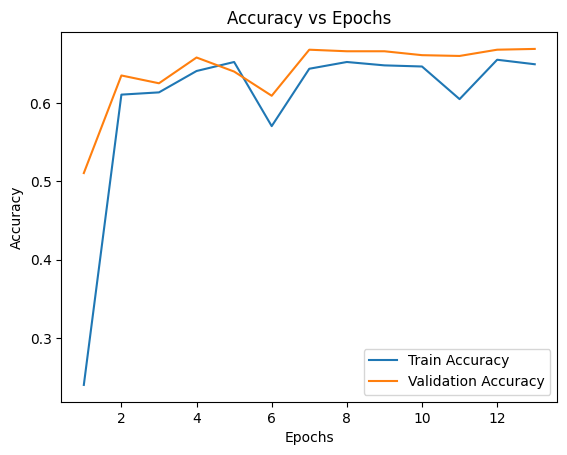

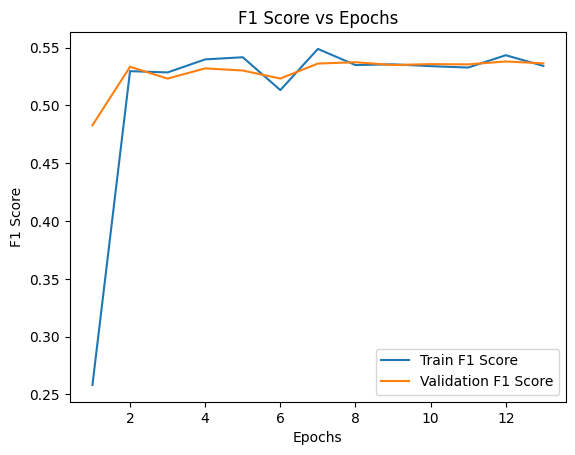

Run 3 - Final Val Accuracy: 0.6690
Run 3 - Final Val F1:       0.5363
Run 3 - Final Val Loss:     1.2330

===== SUMMARY OVER MULTIPLE RUNS =====
Validation Loss: 1.2301 ± 0.0027
Validation Accuracy: 0.6660 ± 0.0035
Validation F1: 0.5353 ± 0.0013

 Final Val Accuracy = 0.6660 ± 0.0035


In [28]:
def train_subset_model_multiple_runs(
    device,
    num_runs=3,
    percentage=10,
    num_epochs=30,
    lr=0.001,
    patience=5,
    accumulation_steps=4,
    seed=42
):

    set_seed(seed)

    train_loader_subset, val_loader_subset, test_loader_subset = load_data_subset(
        batch_size=batch_size,
        img_size=img_size,
        percentage=percentage
    )

    val_accuracies = []
    val_f1s = []
    val_losses = []

    for run_idx in range(num_runs):
        print(f"\n===== RUN {run_idx + 1}/{num_runs} (Percentage={percentage}%) =====")
        #  same data shuffle for each run
        set_seed(seed + run_idx)  
        model = ViTModel(num_classes=num_classes)


        metrics_log = train_subset_model(
            model=model,
            train_loader_subset=train_loader_subset,
            val_loader_subset=val_loader_subset,
            device=device,
            num_epochs=num_epochs,
            lr=lr,
            patience=patience,
            accumulation_steps=accumulation_steps
        )


        final_val_accuracy = metrics_log["val_accuracy"][-1]
        final_val_f1 = metrics_log["val_f1"][-1]
        final_val_loss = metrics_log["val_loss"][-1]

        val_accuracies.append(final_val_accuracy)
        val_f1s.append(final_val_f1)
        val_losses.append(final_val_loss)


        print(f"Run {run_idx + 1} - Final Val Accuracy: {final_val_accuracy:.4f}")
        print(f"Run {run_idx + 1} - Final Val F1:       {final_val_f1:.4f}")
        print(f"Run {run_idx + 1} - Final Val Loss:     {final_val_loss:.4f}")

    # Mean ± Std
    val_loss_mean = np.mean(val_losses)
    val_loss_std = np.std(val_losses)
    val_acc_mean = np.mean(val_accuracies)
    val_acc_std = np.std(val_accuracies)
    val_f1_mean = np.mean(val_f1s)
    val_f1_std = np.std(val_f1s)


    print("\n===== SUMMARY OVER MULTIPLE RUNS =====")
    print(f"Validation Loss: {val_loss_mean:.4f} ± {val_loss_std:.4f}")
    print(f"Validation Accuracy: {val_acc_mean:.4f} ± {val_acc_std:.4f}")
    print(f"Validation F1: {val_f1_mean:.4f} ± {val_f1_std:.4f}")

    return {
        "val_loss_mean": val_loss_mean,
        "val_loss_std": val_loss_std,
        "val_acc_mean": val_acc_mean,
        "val_acc_std": val_acc_std,
        "val_f1_mean": val_f1_mean,
        "val_f1_std": val_f1_std
    }

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=10,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")


In [ ]:
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    results = train_subset_model_multiple_runs(
        device=device,
        num_runs=3,
        percentage=1,
        num_epochs=30,
        lr=0.001,
        patience=5,
        accumulation_steps=4,
        seed=42
    )

    print(f"\n Final Val Accuracy = {results['val_acc_mean']:.4f} ± {results['val_acc_std']:.4f}")



===== RUN 1/3 (Percentage=1%) =====


Training Epoch 1/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th

Epoch [1/30]:
  Train Loss: 2.1629, Accuracy: 0.0746, F1: 0.1069
  Val Loss: 2.3516, Accuracy: 0.0947, F1: 0.1316
Validation loss improved. Model saved.


Training Epoch 2/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th

Epoch [2/30]:
  Train Loss: 2.2554, Accuracy: 0.1791, F1: 0.2485
  Val Loss: 2.3551, Accuracy: 0.1007, F1: 0.1350
No improvement in validation loss for 1 epoch(s).


Training Epoch 3/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th

Epoch [3/30]:
  Train Loss: 2.2586, Accuracy: 0.1642, F1: 0.2099
  Val Loss: 2.3536, Accuracy: 0.0768, F1: 0.1001
No improvement in validation loss for 2 epoch(s).


Training Epoch 4/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th

Epoch [4/30]:
  Train Loss: 2.4076, Accuracy: 0.1045, F1: 0.1787
  Val Loss: 2.3445, Accuracy: 0.0997, F1: 0.1281
Validation loss improved. Model saved.


Training Epoch 5/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th

Epoch [5/30]:
  Train Loss: 2.6205, Accuracy: 0.1642, F1: 0.2167
  Val Loss: 2.3421, Accuracy: 0.0917, F1: 0.1192
Validation loss improved. Model saved.


Training Epoch 6/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th

Epoch [6/30]:
  Train Loss: 2.7880, Accuracy: 0.1343, F1: 0.2168
  Val Loss: 2.3346, Accuracy: 0.0867, F1: 0.1164
Validation loss improved. Model saved.


Training Epoch 7/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th

Epoch [7/30]:
  Train Loss: 2.1628, Accuracy: 0.1940, F1: 0.2744
  Val Loss: 2.2955, Accuracy: 0.0897, F1: 0.1155
Validation loss improved. Model saved.


Training Epoch 8/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th

Epoch [8/30]:
  Train Loss: 2.3999, Accuracy: 0.0746, F1: 0.1032
  Val Loss: 2.2896, Accuracy: 0.0957, F1: 0.1258
Validation loss improved. Model saved.


Training Epoch 9/30:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_9416/720293909.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(label) # int label 1d
/home/dime/anaconda3/envs/new_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from th